Compute only $\chi$ and F from data to get time frame of computing the essentials

In [171]:
# Import necessary libraries
import numpy as np
import glob

# Import external background functions
%run background_functions.py

In [2]:
# Import HCP data
# Importing all matrices with Numpy
matrices = [np.genfromtxt(file) for file in glob.glob('./1000_Functional_Connectomes/Connectivity matrices/*_matrix_file.txt')]

# Generate an averaged matrix
MatAv = np.zeros(shape=matrices[0].shape)
for matrix in matrices:
    MatAv += matrix
averaged_matrix = MatAv/len(matrices)

In [128]:
# Define desired settings
cutoff=0.5 # Value between 0 and 1. Values below this value are set to zero. Becomes obsolete after including phase randomisation
max_dim=4
M = averaged_matrix

In [129]:
# Compute the clique complex and Euler Characteristic
%time euler_characteristic, clique_complex = compute_euler(M,cutoff,max_dim)

CPU times: total: 0 ns
Wall time: 12.2 ms


In [130]:
# Generate the connectivity matrix L from the clique complex
%time inverse_connectivity_matrix = generate_inverse_connectivity_matrix(clique_complex)

CPU times: total: 469 ms
Wall time: 270 ms


In [167]:
# Compute the Helmholtz free energy
%time U_min, p_Umin, S_max, p_Smax, Free_energy = free_energy(inverse_connectivity_matrix, 1)

C:\Users\cyril\Documents\GitHub\Free_energy_of_simplicial_complexes\background_functions.py:34: RuntimeWarning: overflow encountered in exp
  if new_value < current_value or np.random.rand() > np.exp((new_value - current_value) / temperature):


CPU times: total: 10.7 s
Wall time: 23.1 s


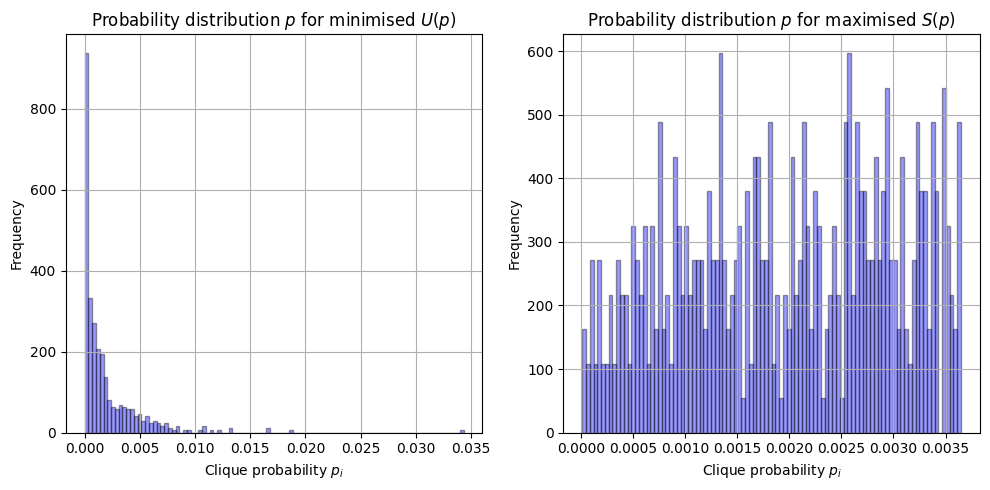

In [165]:
# Plotting the probability distribution
plt.figure(figsize=(10, 5))

# Plot the energy/entropy evolution against the number of Simulated Annealing iterations

plt.subplot(1, 2, 1)
plt.hist(p_Umin, bins=100, density=True, alpha=0.4, color='blue', edgecolor='black')
plt.xlabel('Clique probability $p_i$')
plt.ylabel('Frequency')
plt.title('Probability distribution $p$ for minimised $U(p)$')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(p_Smax, bins=100, density=True, alpha=0.4, color='blue', edgecolor='black')
plt.xlabel('Clique probability $p_i$')
plt.ylabel('Frequency')
plt.title('Probability distribution $p$ for maximised $S(p)$')
plt.grid(True)

plt.tight_layout()
plt.show()

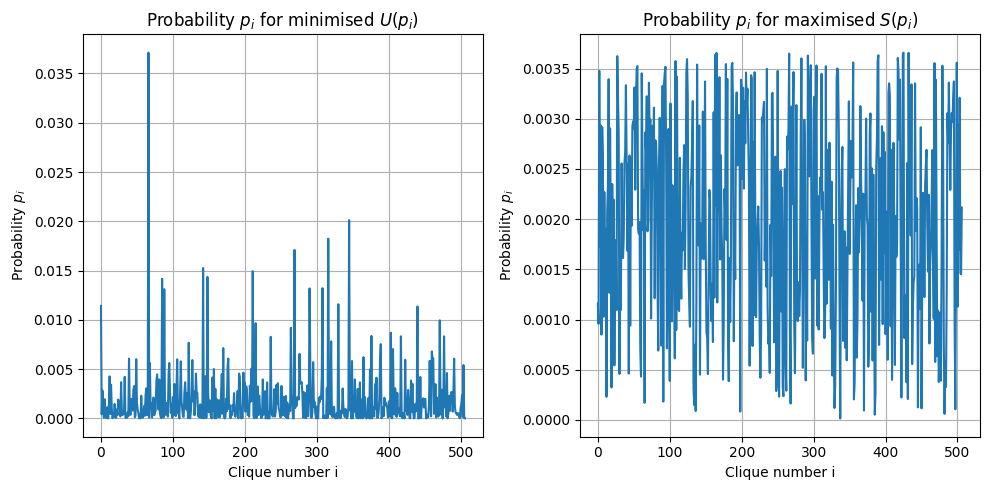

In [149]:
# Plotting the probability distribution
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(p_Umin)
plt.xlabel('Clique number i')
plt.ylabel('Probability $p_i$')
plt.title('Probability $p_i$ for minimised $U(p_i)$')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(p_Smax)
plt.xlabel('Clique number i')
plt.ylabel('Probability $p_i$')
plt.title('Probability $p_i$ for maximised $S(p_i)$')
plt.grid(True)

plt.tight_layout()
plt.show()

Compare sampling for alternative distributions, since the optimised value should converge to a constant minimum.

In [172]:
# Example for generating energy and entropy data from a given matrix
list_size = len(M)
num_iterations_energy = 20000
num_iterations_entropy = 10000
sampling_distributions = ['uniform', 'normal', 'poisson', 'chisquare', 'gamma', 'pareto', 'lognormal', 'genpareto']
energy_probabilities = []
entropy_probabilities = []

for _ in sampling_distributions:
    initial_probabilities = generate_probability_list(list_size, _)
    # Minimum internal energy with simulated annealing
    energy_history, current_probabilities_energy = simulated_annealing_energy(initial_probabilities, _ , M, num_iterations_energy)
    # Maximum shannon entropy with simulated annealing
    entropy_history, current_probabilities_entropy = simulated_annealing_entropy(initial_probabilities, _ , num_iterations_entropy)
    # Store probabilities type
    energy_probabilities.append(energy_history)
    entropy_probabilities.append(entropy_history)

C:\Users\cyril\Documents\GitHub\Free_energy_of_simplicial_complexes\background_functions.py:35: RuntimeWarning: overflow encountered in exp
  current_probabilities = new_probabilities
C:\Users\cyril\Documents\GitHub\Free_energy_of_simplicial_complexes\background_functions.py:35: RuntimeWarning: overflow encountered in scalar divide
  current_probabilities = new_probabilities
C:\Users\cyril\Documents\GitHub\Free_energy_of_simplicial_complexes\background_functions.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  current_probabilities = new_probabilities


In [120]:
# Maximum shannon entropy from uniform distribution
n = len(matrix)
p_Smax = np.ones(n) / n
max_entropy_value = shannon_entropy(p_Smax)
max_entropy = [max_entropy_value]*num_iterations_entropy

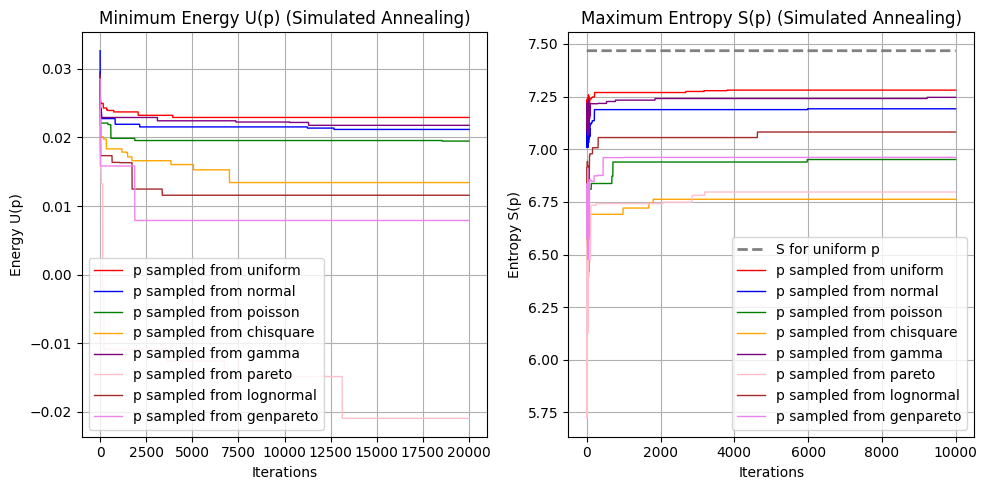

In [173]:
# Plotting the optimisation side by side
plt.figure(figsize=(10, 5))
colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink', 'brown', 'violet']

# Plot the energy/entropy evolution against the number of Simulated Annealing iterations

plt.subplot(1, 2, 1)
for i in range(len(sampling_distributions)):
    plt.plot(energy_probabilities[i], color=colors[i], linestyle='-', linewidth=1, label = f'p sampled from {sampling_distributions[i]}')
plt.title('Minimum Energy U(p) (Simulated Annealing)')
plt.xlabel('Iterations')
plt.ylabel('Energy U(p)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(max_entropy, color='grey', linestyle='--', linewidth = 2, label='S for uniform p')
for i in range(len(sampling_distributions)):
    plt.plot(entropy_probabilities[i], color=colors[i], linestyle='-', linewidth=1, label = f'p sampled from {sampling_distributions[i]}')
plt.title('Maximum Entropy S(p) (Simulated Annealing)')
plt.xlabel('Iterations')
plt.ylabel('Entropy S(p)')
plt.legend()
plt.grid(True)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

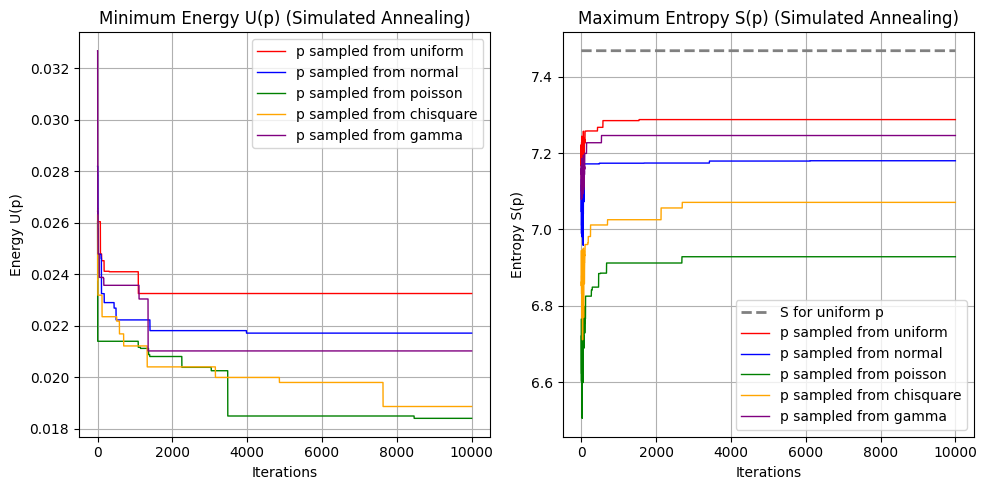

In [154]:
# Plotting the optimisation side by side
plt.figure(figsize=(10, 5))
colors = ['red', 'blue', 'green', 'orange', 'purple']

# Plot the energy/entropy evolution against the number of Simulated Annealing iterations

plt.subplot(1, 2, 1)
for i in range(len(sampling_distributions)):
    plt.plot(energy_probabilities[i], color=colors[i], linestyle='-', linewidth=1, label = f'p sampled from {sampling_distributions[i]}')
plt.title('Minimum Energy U(p) (Simulated Annealing)')
plt.xlabel('Iterations')
plt.ylabel('Energy U(p)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(max_entropy, color='grey', linestyle='--', linewidth = 2, label='S for uniform p')
for i in range(len(sampling_distributions)):
    plt.plot(entropy_probabilities[i], color=colors[i], linestyle='-', linewidth=1, label = f'p sampled from {sampling_distributions[i]}')
plt.title('Maximum Entropy S(p) (Simulated Annealing)')
plt.xlabel('Iterations')
plt.ylabel('Entropy S(p)')
plt.legend()
plt.grid(True)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()